# Practical Session 3
## Kernel Methods for Machine Learning

Written by Yunlong Jiao / Romain Menegaux, 20 May 2020


* [Part I - Basics](#part1)
    1. [Generating data](#generating-data)
    2. [SVM scikit-learn implementation](#scikit-implementation)
    3. [Plotting the results](#plotting)
* [Part II - Tuning C](#part2)
    1. [Choosing C by cross-validation](#cross-validation)
    2. [Influence of C on error](#best-C)
    3. [Interactive Plot](#interactive-plot)
* [Part III - Custom Implementation using Quadratic Programming](#part3)
    1. [Hard Margin](#hard-margin)
       * [Primal](#hard-margin-primal)
       * [Dual](#hard-margin-dual)
       * [Getting w and b from dual solution](#primal-from-dual-hard)
       * [Non separable data](#non-separable)
    2. [Soft Margin](#soft-margin)
       * [Primal](#soft-margin-primal)
       * [Dual](#soft-margin-dual)

In [1]:
# setup
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys
print(sys.version)

2.7.3 |Continuum Analytics, Inc.| (default, Dec 20 2012, 09:57:39) 
[GCC 4.0.1 (Apple Inc. build 5493)]


In [3]:
import sklearn
sklearn.__version__

'0.19.0'

In [31]:
solver='cvxopt'
# import sys
# try:
#     # !pip install cvxopt
#     !conda install --yes --prefix {sys.prefix} cvxopt
#     solver = 'cvxopt'
# except:
#     try:
#         !conda install --yes --prefix {sys.prefix} -c omnia quadprog
#         # !pip install quadprog
#         solver = 'quadprog'
#     except:
#         solver = None
#         
# if solver == 'quadprog':
#     import quadprog
#     print('Using quadprog')
# elif solver == 'cvxopt':
#     import cvxopt
#     print('Using cvxopt')
# else:
#     print('No QP solver installed')

In [5]:
import cvxopt

***
## Part I - Basics <a name="part1"></a>

### Generating data <a name="generating-data"></a> 
- **Generate 20 binary classification samples** (10 from each class $y = 1$ and $y = −1$).
$$$$
Use $\mathbf{x} \in \mathbb{R}^2$, for visualization purpose, where each element $x \sim \mathcal{N}(\mu_y,\sigma^2), \mu_1 = 0, \mu_{-1}=1$.
$$$$
- **Generate 1000 separate testing samples from the same distribution**
- **Visualize training data.**
$$$$

In [10]:
# Simulate data
np.random.seed(54321)
p = 2

def generate_Xy(n_samples, p=2, sigma=.2):
    # Half of y is 1s, other half is -1
    y = np.ones(n_samples)
    mid = int(n_samples / 2)
    y[mid:] *= -1
    
    X = np.random.normal(0, sigma, (n_samples, p))
    X += (1 - y[:, np.newaxis]) / 2 # add 1 when y = -1
    # X of shape (n, p)
    # y vector of length n
    return X, y

# Training data
X_train, y_train = generate_Xy(20)

# Testing data
X_test, y_test = generate_Xy(1000)

In [11]:
# Prediction error
def error(y_pred, y_true):
    e = (y_pred != y_true).mean()
    return e

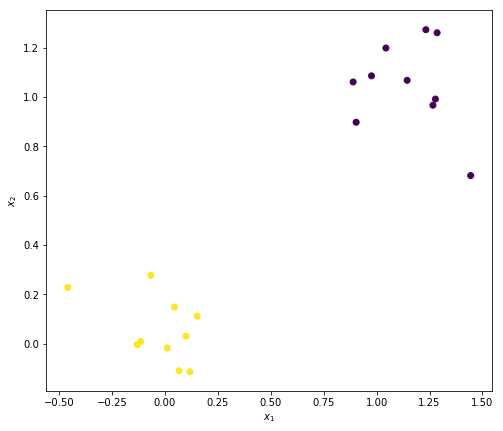

In [12]:
# Visualize training data
def plot_data(X, y):
    plt.figure(figsize=(8,7))
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()
    
plot_data(X_train, y_train)

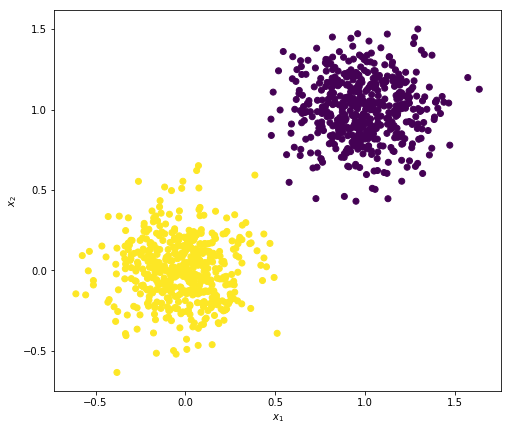

In [13]:
plot_data(X_test, y_test)

## SVM scikit-learn implementation <a name="scikit-implementation"></a>
**Train a linear SVM** with parameter $C = 10$ on the training set, using the function `sklearn.svm.LinearSVC`. Inspect the resulting object

In [14]:
from sklearn.svm import LinearSVC

# Parameters
C = 1

# Create the model
clf = LinearSVC(penalty='l2', C=C)
# Train the model
clf.fit(X_train, y_train)
clf.__dict__

{'C': 1,
 'class_weight': None,
 'classes_': array([-1.,  1.]),
 'coef_': array([[-0.93054661, -0.88188023]]),
 'dual': True,
 'fit_intercept': True,
 'intercept_': array([0.94747116]),
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'n_iter_': 46,
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [15]:
w = clf.coef_[0]
b = clf.intercept_[0]
print('Model parameters:')
print('w: {}'.format(w))
print('b: {}'.format(b))

Model parameters:
w: [-0.93054661 -0.88188023]
b: 0.947471156831


In [16]:
# Training error
y_fit = clf.predict(X_train)
err_train = error(y_fit, y_train)
print('Training error = {:.1%}'.format(err_train))

# Testing error
y_pred = clf.predict(X_test)
err_test = error(y_pred, y_test)
print('Testing error = {:.1%}'.format(err_test))

Training error = 0.0%
Testing error = 0.0%


#### Reminder

SVM as a model:
$\hat{y} = sign(w^\top x + b)$

Goal: find the best possible $w$ and $b$
$$$$

**Our implementation of `clf.predict`**:

In [17]:
# What clf.predict does under the hood:
y_fit = np.sign(X_train.dot(w) + b)
err_train = error(y_fit, y_train)
print('Training error = {:.1%}'.format(err_train))

Training error = 0.0%


***
### Plot the points and the decision boundaries of a linear SVM <a name="plotting-margins"></a>
Recall: 
the boundary (separating hyperplane) is the set of points for which $f(x) = 0$.

$f(x) = w^\top x + b = w_1 x_1 + w_2 x_2 + b$

- **Separating hyperplane**
$$w_1 x_1 + w_2 x_2 + b = 0$$
$$x_2 = -\frac{1}{w_2}(w_1x_1 + b)$$

- **Margins**
$$f(x) = 1$$
$$f(x) = -1$$
The decision boundaries are $$b + w_1x_1 + w_2x_2 = 1$$ and $$b + w_1x_1 + w_2x_2 = -1$$

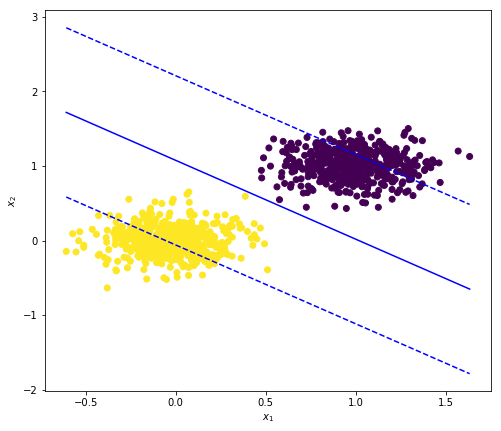

In [18]:
# Visualize training data and separating hyperplane
def compute_margins(b, w1, w2, x1):
    '''
    returns x2 such that:
        - f(x) = 0
        - f(x) = 1
        - f(x) = -1
    '''
    x2 = (-b - w1 * x1) / w2
    x2_up = (-b - w1 * x1 - 1) / w2
    x2_low = (-b - w1 * x1 + 1) / w2
    
    return x2, x2_up, x2_low

def plot_points_with_margin(X, y, w, b):
    plt.figure(figsize=(8,7))

    # Training data
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

    # Separating hyperplane and decision boundaries
    x1 = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    w1, w2 = w
    x2, x2_up, x2_low = compute_margins(b, w1, w2, x1)

    plt.plot(x1, x2, 'b')
    plt.plot(x1, x2_up, 'b--')
    plt.plot(x1, x2_low, 'b--')

    # Plot
    plt.show()
    
w = clf.coef_[0]
b = clf.intercept_[0]
plot_points_with_margin(X_test, y_test, w, b)

## Part II - Tuning C <a name="part2"></a>
- Try different values of $C$, and visualize the effect of $C$ on the margin and number of support vectors.
$$$$
- Train a linear SVM with values of $C$ between $10^{−3}$ and $1$. Plot and analyze the training and testing classification errors as a function of $C$. Question: Why can't we overfit more?
$$$$
- Choose $C$ by cross-validation.

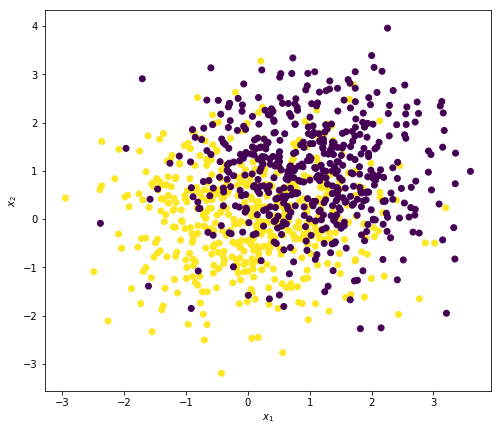

In [25]:
# Let's make the data non-separable
# Training data
X_train2, y_train2 = generate_Xy(20, sigma=1)
# Testing data
X_test2, y_test2 = generate_Xy(1000, sigma=1)

plot_data(X_test2, y_test2)

### Choosing C by cross-validation <a name="cross-validation"></a>

In [26]:
from sklearn.model_selection import cross_val_score

# Cross validation
CL = 10 ** np.linspace(-3, 2, 100)
cvsL = np.zeros(len(CL))

for i,C in enumerate(CL):
    clf = sklearn.svm.LinearSVC(penalty='l2',loss='hinge',C=C)
    scores = cross_val_score(clf, X_train2, y_train2, cv=5, scoring='accuracy')
    cvsL[i] = scores.mean()
    
best_index = np.argmax(cvsL)
best_C = CL[best_index]

# Training with cross-validated C
clf_best = sklearn.svm.LinearSVC(penalty='l2', loss='hinge', C=best_C)
clf_best.fit(X_train2, y_train2)

print('Results with optimal C')
print('----------------------')
# Training error
y_fit = clf_best.predict(X_train2)
err_train = error(y_fit, y_train2)
print('Training error = {:.1%}'.format(err_train))

# Testing error
y_pred = clf_best.predict(X_test2)
err_test = error(y_pred, y_test2)
print('Testing error = {:.1%}'.format(err_test))

Results with optimal C
----------------------
Training error = 20.0%
Testing error = 30.5%


### Influence of $C$ on performance <a name="best-C"></a>

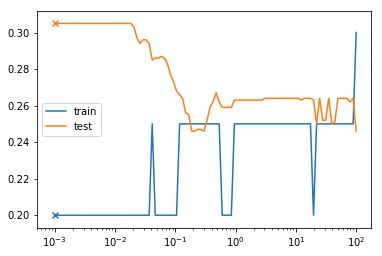

In [27]:
# Train-test error curve
err_train = np.zeros(len(CL))
err_test = np.zeros(len(CL))

# OPTIONAL
# We also store the model coefficients to plot the decision boundaries
w0 = np.zeros_like(CL)
w = np.zeros((len(CL), p))

for i, C in enumerate(CL):
    # print('C = ', C)
    clf = sklearn.svm.LinearSVC(penalty='l2',loss='hinge',C=C)
    clf.fit(X_train2, y_train2)
    
    # Store model coefs
    w0[i] = clf.intercept_[0]
    w[i] = clf.coef_[0]

    # Training error
    y_fit = clf.predict(X_train2)
    err_train[i] = error(y_fit, y_train2)
    # print('Training error = ', err_train[i])
    
    # Testing error
    y_pred = clf.predict(X_test2)
    err_test[i] = error(y_pred, y_test2)
    # print('Testing error = ', err_test[i])

# Plot training and testing error as a function of C
plt.figure()
plt.plot(CL, err_train, label='train')
plt.xscale('log')
plt.plot(CL, err_test, label='test')
plt.legend()
plt.scatter(best_C, err_train[best_index], marker='x', label='train')
plt.scatter(best_C, err_test[best_index], marker='x', label='test')
plt.show()

### Interactive plot <a name="interactive-plot"></a>

In [28]:
try:
    import bqplot.pyplot as bqp
    from ipywidgets import IntSlider, HTML, HBox, VBox
except:
    !conda install

x1 = np.linspace(X_test2[:,0].min(), X_test2[:,0].max(), 100)

slider_C = IntSlider(min=0, max=len(CL)-1, value=len(CL)/2, readout=False)
readout = HTML()
fig = bqp.figure(min_aspect_ratio=1.1, max_aspect_ratio=1.1,
           layout={'min_width': '500px', 'min_height': '500px'})
scat = bqp.scatter(X_test2[::2, 0], X_test2[::2, 1],
                   colors=['orange' if y == 1 else 'purple' for y in y_test2[::2]])
                   #axes_options={'color': None})
sep = bqp.plot(x1, np.zeros_like(x1), preserve_domain={'x': True, 'y': True})
margin_up = bqp.plot(x1, np.zeros_like(x1), '--', preserve_domain={'x': True, 'y': True})
margin_down = bqp.plot(x1, np.zeros_like(x1), '--', preserve_domain={'x': True, 'y': True})

def compute_margins(w0, w1, w2, x1):
    x2 = (-w0 - w1 * x1) / w2
    x2_up = (-w0 - w1 * x1 - 1) / w2
    x2_low = (-w0 - w1 * x1 + 1) / w2
    
    return x2, x2_up, x2_low

def update_margins(*args):
    i = slider_C.value
    sep.y, margin_up.y, margin_down.y = compute_margins(w0[i], w[i, 0], w[i, 1], sep.x)
    readout.value = 'C = {:.3f}'.format(CL[i])

slider_C.observe(update_margins)
update_margins()

#bqp.show()
VBox([fig, HBox([slider_C, readout])])

***
## Part III <a name="part3"></a>
We will use a quadratic program (QP) solver `cvxopt` to find our own solution to SVM

```
cvxopt.solvers.qp(P, q[, G, h[, A, b]])
```
solves the quadratic program

$$
\begin{aligned}
\min_x & \, \frac{1}{2}x^\top P x + q^\top x \\
\mathrm{s.t. } \, & Gx \leq h \\
& Ax = b
\end{aligned}
$$

- $P, q$ define the objective
- $G, h$ are all the inequality constraints
- $A, b$ are all the equality constraints

**Goal: Find $P$, $q$, $G$, $h$, $A$ and $b$ for SVM**
***

### Hard Margin SVM <a name="hard-margin"></a>
(See slide 83)

#### Primal problem <a name="hard-margin-primal"></a>
$$
\begin{aligned}
\min_{w, b} & \, \frac{1}{2}w^\top w \\
\mathrm{s.t. } \, & y_i x_i^\top w + y_i b \geq 1 \,\,\,, \forall i \in [1, n]\\
\end{aligned}
$$

First step: what is $x$ in our case, with the slides notations?

$x = (w_1, ..., w_p, b)^T \in \mathbb{R}^{p+1}$

***
**We set $X_y = \mathrm{diag}(y)X = (y_1x_1, ..., y_nx_n)^\top \in \mathbb{R}^{n\times p}$**

$X_y$ is simply $X$ with its rows $i$ multiplied by $y_i$

In [32]:
# You don't need to look at this, this is just to adapt our matrices
# to the solver being used

def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    if A is not None:
        qp_C = -np.vstack([A, G]).T
        qp_b = -np.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = - G.T
        qp_b = - h
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

def cvxopt_qp(P, q, G, h, A, b):
    P = .5 * (P + P.T)
    cvx_matrices = [
        cvxopt.matrix(M) if M is not None else None for M in [P, q, G, h, A, b] 
    ]
    solution = cvxopt.solvers.qp(*cvx_matrices)
    return np.array(solution['x']).flatten()

solve_qp = {'quadprog': quadprog_solve_qp, 'cvxopt': cvxopt_qp}[solver]

### Hard margin SVM

**Primal**
$$
\begin{aligned}
\min_{w, b} & \, \frac{1}{2}w^\top w \\
\mathrm{s.t. } \, & y_i x_i^\top w + y_i b \geq 1\\
\end{aligned}
$$

<font color='red'> Watch out for the signs in the constraints! </font>

- <font color='green'>$P = \mathrm{diag}(1, ..., 1, 0)$</font> ($P$ is $I_{p+1}$ with a 0 instead of the last 1)
$$$$
- <font color='green'> $q = \mathbf{0}_{p+1}$</font>
- <font color='green'>$G = -[X_y, y]$</font> Add $y$ column at the end of $X_y$ (to multiply with $b$)
$$$$
- <font color='green'> $h = -\mathbf{1}_{n}$</font>
- <font color='green'>$A = 0, b = 0$</font>

You can check that: $$x^\top P x = \frac{1}{2} w^\top w$$
and
$$Gx = -X_y w + by$$

### Let's implement it!

In [33]:
def svm_primal_hard_to_qp(X, y):
    n, p = X.shape
    assert (len(y) == n)
    
    Xy = np.diag(y).dot(X)
    # Primal formulation, hard margin
    diag_P = np.ones(p + 1) # correct this!
    diag_P[-1] = 0 # The one multiplies with b
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    diag_P += eps
    P = np.diag(diag_P)
    
    q = np.zeros(p + 1)
    G = np.hstack([Xy, y[:, np.newaxis]]) # newaxis transforms y into column matrix
    # G = np.vstack([Xy.T, y]).T
    h = - np.ones(n)
    A = None
    b = None
    
    return P, q, G, h, A, b

x = solve_qp(*svm_primal_hard_to_qp(X_train, y_train))
n, p = X_train.shape
w, b = x[:-1], x[-1]

     pcost       dcost       gap    pres   dres
 0:  6.8295e-01  3.8440e+00  3e+01  1e+00  2e+01
 1:  3.5650e+00  3.3222e-01  3e+00  4e-16  9e-15
 2:  1.7687e+00  1.1670e+00  6e-01  3e-16  1e-15
 3:  1.7833e+00  1.6055e+00  2e-01  2e-16  1e-15
 4:  1.6940e+00  1.6888e+00  5e-03  3e-16  4e-15
 5:  1.6928e+00  1.6928e+00  5e-05  2e-16  1e-14
 6:  1.6928e+00  1.6928e+00  5e-07  3e-16  6e-15
Optimal solution found.


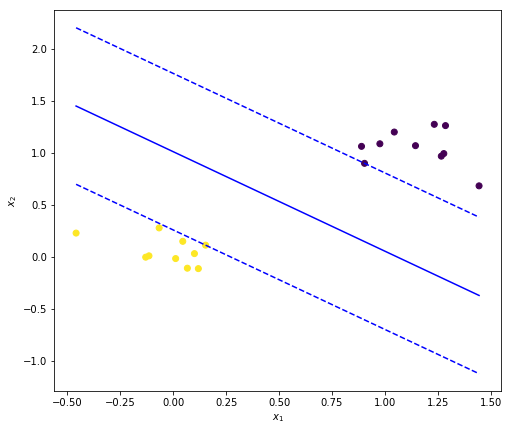

In [34]:
plot_points_with_margin(X_train, y_train, w, b)

#### Dual: <a name="hard-margin-dual"></a>
$$
\begin{aligned}
\max_\alpha & \, \mathrm{1}^\top\alpha - \frac{1}{2}\alpha^\top X_y X_y^\top \alpha \\
\mathrm{s.t. } \, & \alpha \geq 0 \\
& y^\top\alpha = 0
\\
\end{aligned}
$$

You can verify that:
$$
L(\alpha) =  -\frac{1}{2}\sum_{i, j} \alpha_i \alpha_j x_i^\top x_j y_i y_j + \sum_i \alpha_i = -\frac{1}{2} \alpha^\top X_y X_y^\top \alpha + \mathbf{1}^\top\alpha
$$

- <font color='green'>$x = \alpha \in \mathbb{R}^{n}$</font>
- <font color='green'> $P = X_y^T X_y$, $q = -\mathbf{1}_n$ </font> minus sign because maximisation instead of minimization!
- <font color='green'> $G = -I_n, h = \mathbf{0}_n$</font>
- <font color='green'> $A = y^\top, b = 0$ </font>

Then implement it below:

In [35]:
def svm_dual_hard_to_qp(X, y):
    n, p = X.shape
    assert (len(y) == n)
    
    Xy = np.diag(y).dot(X)
    # Dual formulation, hard margin
    P = Xy.dot(Xy.T)
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    P += eps * np.eye(n)
    
    q = -np.ones(n)
    G = -np.eye(n)
    h = np.zeros(n)
    A = y.reshape(1,-1)
    # A = y.T
    b = np.zeros((1,1))

    return P, q, G, h, A, b

alphas = solve_qp(*svm_dual_hard_to_qp(X_train, y_train))

     pcost       dcost       gap    pres   dres
 0: -1.3883e+00 -3.6455e+00  3e+01  5e+00  1e+00
 1: -3.3222e-01 -3.5650e+00  3e+00  1e-15  5e-16
 2: -1.1670e+00 -1.7687e+00  6e-01  7e-16  3e-16
 3: -1.6055e+00 -1.7833e+00  2e-01  8e-16  4e-16
 4: -1.6888e+00 -1.6940e+00  5e-03  5e-16  4e-16
 5: -1.6928e+00 -1.6928e+00  5e-05  6e-17  5e-16
 6: -1.6928e+00 -1.6928e+00  5e-07  2e-16  4e-16
Optimal solution found.


### How do we find $w$ and $b$ from $\alpha$? $$$$<a name="primal-from-dual-hard"></a>
$$$$

Answer is in slide 82

- <font color='green'> $w = \sum_i \alpha_i y_i x_i$ </font>
- For the bias $b$, use the support vectors $i^*$:
$$$$
    **Point $i^*$ is a support vector if <font color='green'>$0<\alpha_i^*<C$</font>**, in which case:
    <font color='green'>$$b = y_{i^*} - w^\top x_{i^*}$$</font>

Alphas = [1.69279454 1.69279689]
Number of support vectors = 2
w = [-1.27116827 -1.3303106 ]
b = 1.3429887988


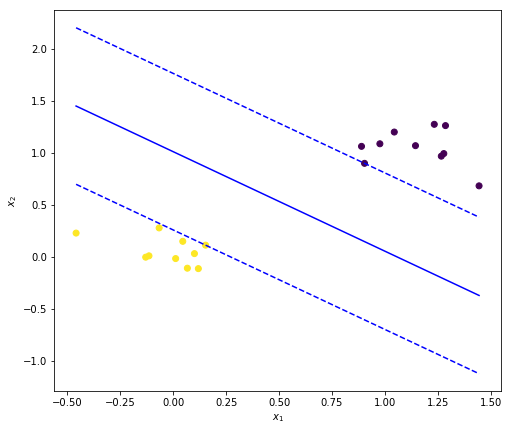

In [36]:
def get_primal_from_dual(alpha, X, y, hard_margin=False, C=None, tol=1e-3):
    # w parameter in vectorized form
    w = ((y * alpha).T.dot(X)).flatten()
    # w = X.dot(y[:, np.newaxis]*alphas)
    
    # sv = Support vectors!
    # Indices of points (support vectors) that lie exactly on the margin
    # Filter out points with alpha == 0
    sv = (alpha > tol)
    # If soft margin, also filter out points with alpha == C
    if not hard_margin:
        if C is None:
            raise ValueError('C must be defined in soft margin mode')
        sv = np.logical_and(sv, (C - alpha > tol))
    b = y[sv] - X[sv].dot(w)
    b = b[0]
    
    #Display results
    print('Alphas = {}'.format(alpha[sv]))
    print('Number of support vectors = {}'.format(sv.sum()))
    print('w = {}'.format(w))
    print('b = {}'.format(b))
    
    return w, b

w, b = get_primal_from_dual(alphas, X_train, y_train, hard_margin=True)
plot_points_with_margin(X_train, y_train, w, b)

Primal == Dual !

#### Does not work if data is not linearly separable! <a name="non-separable"></a>

In [37]:
X_non_separable, y_non_separable = generate_Xy(20, sigma=2)
solve_qp(*svm_primal_hard_to_qp(X_non_separable, y_non_separable))

     pcost       dcost       gap    pres   dres
 0:  5.5486e-02  2.1474e+01  7e+01  3e+00  4e+01
 1:  6.6416e-02  4.8863e+01  4e+01  2e+00  3e+01
 2:  1.7800e-03  1.6418e+02  4e+01  1e+00  2e+01
 3:  6.9006e-04  5.0093e+02  7e+01  1e+00  2e+01
 4:  1.7044e-04  2.5930e+03  2e+02  1e+00  2e+01
 5:  9.1985e-05  1.3597e+04  7e+02  1e+00  2e+01
 6:  2.5821e-05  1.5090e+05  4e+03  1e+00  2e+01
 7:  8.1839e-07  5.0783e+06  2e+04  1e+00  2e+01
 8:  1.4603e-09  1.0685e+09  2e+05  1e+00  2e+01
 9:  1.5268e-13  5.4511e+12  1e+07  1e+00  2e+01
10:  2.0235e-14  1.7454e+18  1e+12  1e+00  2e+04
11:  1.9372e-14  4.8920e+22  3e+16  1e+00  1e+10
12:  1.0357e-14  1.8436e+28  1e+22  1e+00  1e+15
13:  1.0374e-14  4.5276e+30  2e+24  1e+00  1e+21
14:  1.0388e-14  1.7283e+31  9e+24  1e+00  4e+24
15:  1.1026e-14  5.8673e+31  3e+25  1e+00  3e+28
16:  1.1666e-14  7.8750e+33  4e+27  1e+00  3e+28
17:  1.1628e-14  2.5601e+37  1e+31  1e+00  3e+28
18:  9.2431e-15  5.3658e+42  2e+36  1e+00  2e+31
19:  7.3775e-15  1.23

array([ 1.43379258e-11,  6.47366640e-12, -5.52033180e-12])

### Soft margin SVM <a name="soft-margin"></a>
(slides 89, 91)

### Primal (soft margin): <a name="soft-margin-primal"></a>
$$
\begin{aligned}
\min_{w, b, \xi} & \, \frac{1}{2}w^\top w + C \mathbf{1}^\top \xi \\
\mathrm{s.t. } \, & \xi \geq 0 \\
& y_i x_i^\top w + y_i b + \xi_i\geq 1
\\
\end{aligned}
$$

- <font color='green'> $x = (w_1, ..., w_p, b, \xi_1, ..., \xi_n)^T \in \mathbb{R}^{p+1+n}$</font>
- <font color='green'> $P = I_p$ with 0 padding to make it $(p+1+n) \times (p+1+n)$
- $q = (0,..., 0, C, ..., C)$ </font> $q$ is $0$ $(p+1)$ times then $C$ $n$ times
$$$$
- <font color='green'> $G = -\left[X_y^\top, y, I_n\right]^\top$</font>
- <font color='green'> $h = -\mathbf{1}_n^\top$</font>
- <font color='green'> $A = 0, b = 0$ </font>

In [38]:
def svm_primal_soft_to_qp(X, y, C=1):
    n, p = X.shape
    assert (len(y) == n)
    
    Xy = np.diag(y).dot(X)
    # Primal formulation, soft margin
    diag_P = np.hstack([np.ones(p), np.zeros(n + 1)])
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    diag_P += eps
    P = np.diag(diag_P)
    
    q = np.hstack([np.zeros(p + 1), C * np.ones(n)])
    # y(wx+b)+ei>=1
    G1 = - np.hstack([Xy, y[:, np.newaxis], np.eye(n)])
    # ei>=0
    G2 = - np.hstack([np.zeros((n, p+1)), np.eye(n)])
    G = np.vstack([G1, G2])
    h = - np.hstack([np.ones(n), np.zeros(n)])
    A = None
    b = None
    return P, q, G, h, A, b

coefs = solve_qp(*svm_primal_soft_to_qp(X_train, y_train, C=C))
n, p = X_train.shape
w, b, e = coefs[:p], coefs[p], coefs[(p+1):]


     pcost       dcost       gap    pres   dres
 0: -1.7714e+05  6.2595e+03  5e+04  1e+02  2e-01
 1: -8.0042e+03 -2.2780e+03  6e+03  8e+00  1e-02
 2:  3.7680e+02 -3.0595e+02  7e+02  8e-15  2e-15
 3:  5.9607e+01 -3.9068e+01  1e+02  5e-15  3e-16
 4:  1.0537e+01 -3.3462e+00  1e+01  2e-15  2e-16
 5:  2.6317e+00  8.4658e-01  2e+00  4e-16  2e-16
 6:  1.7611e+00  1.2916e+00  5e-01  4e-16  2e-16
 7:  1.7975e+00  1.6215e+00  2e-01  2e-16  1e-16
 8:  1.6943e+00  1.6913e+00  3e-03  3e-16  3e-16
 9:  1.6928e+00  1.6928e+00  3e-05  2e-16  3e-16
10:  1.6928e+00  1.6928e+00  3e-07  3e-16  3e-16
Optimal solution found.


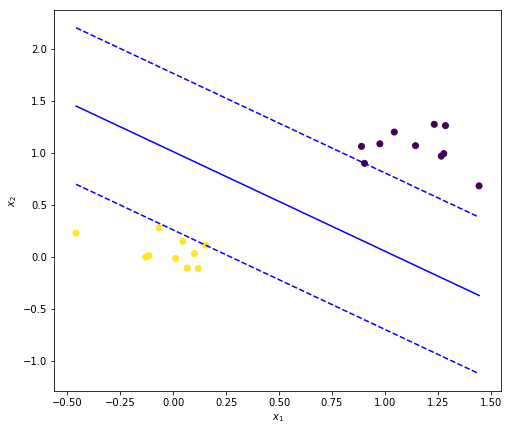

In [39]:
plot_points_with_margin(X_train, y_train, w, b)

### Dual (soft margin): <a name="soft-margin-dual"></a>
$$
\begin{aligned}
\max_\alpha & \, \mathrm{1}^\top\alpha -\frac{1}{2}\alpha^\top X_y^T X_y \alpha \\
\mathrm{s.t. } \, & \alpha \geq 0 \\
& \alpha \leq C \\
& y^\top\alpha = 0
\\
\end{aligned}
$$

- <font color='green'> $x = \alpha \in \mathbb{R}^{n}$ </font>
- <font color='green'> $P = -X_y^T X_y$, $q = -\mathbf{1}$ </font>
- <font color='green'> $G = [-I, I]^\top, h = (0, ..., 0, C, ..., C)^\top$</font> $h$ is $0$ $n$ times then $C$ $n$ times
$$$$
- <font color='green'> $A = y^\top, b = 0$ </font>

In [40]:
def svm_dual_soft_to_qp(X, y, C=1):
    n, p = X.shape
    assert (len(y) == n)
    
    Xy = np.diag(y).dot(X)
    # Dual formulation, soft margin
    P = Xy.dot(Xy.T)
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    P += eps * np.eye(n)
    q = - np.ones(n)
    G = np.vstack([-np.eye(n), np.eye(n)])
    h = np.hstack([np.zeros(n), C * np.ones(n)])
    A = y[np.newaxis, :]
    b = np.array([0.])
    return P, q, G, h, A, b

C = 10
alphas = solve_qp(*svm_dual_soft_to_qp(X_train, y_train, C=C))


     pcost       dcost       gap    pres   dres
 0:  5.2829e+01 -5.6474e+02  1e+03  2e-01  3e-15
 1:  2.9091e+01 -6.2915e+01  1e+02  9e-03  2e-15
 2:  2.7221e+00 -9.2746e+00  1e+01  4e-16  2e-15
 3: -8.6443e-01 -2.3992e+00  2e+00  1e-15  7e-16
 4: -1.2923e+00 -1.7854e+00  5e-01  4e-16  4e-16
 5: -1.6513e+00 -1.7961e+00  1e-01  1e-16  3e-16
 6: -1.6921e+00 -1.6941e+00  2e-03  3e-16  2e-16
 7: -1.6928e+00 -1.6928e+00  2e-05  4e-16  3e-16
 8: -1.6928e+00 -1.6928e+00  2e-07  2e-16  4e-16
Optimal solution found.


#### Finding $w$ and $b$ from $\alpha$ $$$$<a name="primal-from-dual-soft"></a>
$$$$

Answer is in slide 92

- <font color='green'> $w = \sum_i \alpha_i y_i x_i$ </font>
- For the bias $b$, use the support vectors $i^*$:
$$$$
    **Point $i^*$ is a support vector if <font color='green'>$0<\alpha_i^*<C$</font>**, in which case:
    <font color='green'>$$b = y_{i^*} - w^\top x_{i^*}$$</font>

Alphas = [1.69279714 1.69279733]
Number of support vectors = 2
w = [-1.27116779 -1.330311  ]
b = 1.34298877077


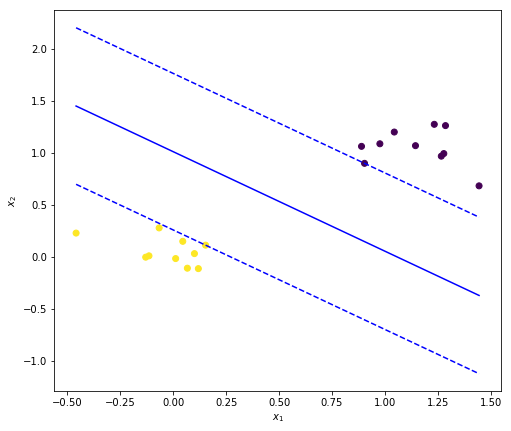

In [41]:
w, b = get_primal_from_dual(alphas, X_train, y_train, C=C)
plot_points_with_margin(X_train, y_train, w, b)